# Electricity Forecasting - FB Prophet

用 Prophet 來預測被轉容量
https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3

In [62]:
import pandas as pd
import numpy as np
import scipy as sp
from prophet import Prophet
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

## 參數設定

In [63]:
n_tests = 15 # numbers of days reserved for testing
n_predictions = 16 # 後面幾天是未來時間，要先刪除
start_offset_first = 0
start_offset_second = 0
start_offset_final = 365
# dependencies = ['prcnt_op_reserve']
# dependencies = ['peak_supply']
dependencies = ['peak_supply', 'prcnt_op_reserve']
first_forecast = 'peak_supply'
second_forecast = 'prcnt_op_reserve'
regressors_first = ['is_holiday', 'month', 'year', 'day']
if first_forecast in dependencies:
    regressors_second = [first_forecast, 'is_holiday', 'month', 'year', 'day']
else:
    regressors_second = ['is_holiday', 'month', 'year', 'day']
regressors_op_reserve = dependencies + ['is_holiday', 'day_of_week', 'month']
print(regressors_op_reserve)

['peak_supply', 'prcnt_op_reserve', 'is_holiday', 'day_of_week', 'month']


## Data Collation / Wrangling

In [64]:
'''
load data
'''
raw_data = []
raw_data = pd.DataFrame(raw_data)

holiday_data = []
holiday_data = pd.DataFrame(holiday_data)

file = 'Data/台灣電力公司_過去電力供需資訊2017.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,['日期','備轉容量(MW)', '備轉容量率(%)']]
raw_data_new.columns=['date','op_reserve', 'prcnt_op_reserve']
for idx, date in enumerate(raw_data_new['date']):
    raw_data_new['op_reserve'][idx] /= 10
    date = str(raw_data_new['date'][idx])
    raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data = pd.concat([raw_data, raw_data_new], ignore_index=True)

file = 'Data/台灣電力公司_過去電力供需資訊2018.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,['日期','備轉容量(MW)', '備轉容量率(%)']]
raw_data_new.columns=['date','op_reserve', 'prcnt_op_reserve']
for idx, date in enumerate(raw_data_new['date']):
    raw_data_new['op_reserve'][idx] /= 10
    date = str(raw_data_new['date'][idx])
    raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data = pd.concat([raw_data, raw_data_new], ignore_index=True)

file = 'Data/近三年每日尖峰備轉容量率2019-2021.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,['日期','備轉容量(萬瓩)', '備轉容量率(%)']]
raw_data_new.columns=['date','op_reserve', 'prcnt_op_reserve']
raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
raw_data = pd.concat([raw_data, raw_data_new], ignore_index=True)

file =  'Data/台灣電力公司_本年度每日尖峰備轉容量率2022.csv'
raw_data_new = pd.read_csv(file)
raw_data_new = pd.DataFrame(raw_data_new)
raw_data_new = raw_data_new.loc[:,[True,True,True]]
raw_data_new.columns = ['date', 'op_reserve', 'prcnt_op_reserve']
raw_data_new['date'] = pd.to_datetime(raw_data_new['date'])
raw_data = pd.concat([raw_data,raw_data_new], ignore_index=True)

forecast_range = pd.date_range(start=raw_data['date'][len(raw_data['date'])-1] + pd.DateOffset(1), end='2022-04-13')
raw_data_new = pd.DataFrame({'date' : forecast_range})
raw_data = pd.concat([raw_data,raw_data_new], ignore_index=True)

raw_data['year']= pd.DatetimeIndex(raw_data['date']).year
raw_data['month']= pd.DatetimeIndex(raw_data['date']).month
raw_data['day']= pd.DatetimeIndex(raw_data['date']).day
raw_data['day_of_week'] = raw_data['date'].dt.dayofweek

# print(raw_data)

for file in ['Data/106年政府機關辦公日曆表.csv',
             'Data/107政府機關辦公日曆表(數字版).csv',
             'Data/108年中華民國政府行政機關辦公日曆表.csv',
             'Data/109年中華民國政府行政機關辦公日曆表.csv',
             'Data/110中華民國政府行政機關辦公日曆表.csv',
             'Data/111年中華民國政府行政機關辦公日曆表.csv']:
    raw_data_new = pd.read_csv(file, encoding= 'unicode_escape')
    raw_data_new = pd.DataFrame(raw_data_new)
    raw_data_new = raw_data_new.loc[:,[True, False, True, False]]
    raw_data_new.columns=['date','is_holiday']
    for idx, date in enumerate(raw_data_new['date']):
        date = str(raw_data_new['date'][idx])
        raw_data_new['date'][idx] = date[:2] + '/'.join(date[i:i+2] for i in range(2, len(date), 2))
    raw_data_new['date']= pd.to_datetime(raw_data_new['date'])
    raw_data_new['year']= pd.DatetimeIndex(raw_data_new['date']).year
    raw_data_new['month']= pd.DatetimeIndex(raw_data_new['date']).month
    raw_data_new['day']= pd.DatetimeIndex(raw_data_new['date']).day
    raw_data_new['day_of_week'] = raw_data_new['date'].dt.dayofweek
    holiday_data = pd.concat([holiday_data, raw_data_new])

raw_data = holiday_data.merge(raw_data)

'''
Trim outliers & convert unit
'''
op_reserve_mean = round(float(raw_data['op_reserve'].mean()), 1)
raw_data['peak_supply'] = raw_data['prcnt_op_reserve'].values
for i, op_reserve in enumerate(raw_data['op_reserve']):
    raw_data['op_reserve'][i] = raw_data['op_reserve'][i] * 10
    raw_data['peak_supply'][i] = raw_data['op_reserve'][i] * 100 / raw_data['prcnt_op_reserve'][i]
    

raw_data.set_index('date').to_csv('training_data.csv')

raw_data = raw_data[:-n_predictions]

'''
split training set and testing set
'''
train = raw_data[start_offset_first:-n_tests]
test = raw_data[-n_tests:]

print(train)
print(test)

           date  is_holiday  year  month  day  day_of_week  op_reserve  \
0    2017-01-02           2  2017      1    2            0      1552.0   
1    2017-01-03           0  2017      1    3            1      1021.0   
2    2017-01-04           0  2017      1    4            2      1272.0   
3    2017-01-05           0  2017      1    5            3      1729.0   
4    2017-01-06           0  2017      1    6            4      1152.0   
...         ...         ...   ...    ...  ...          ...         ...   
1892 2022-03-09           0  2022      3    9            2      2550.0   
1893 2022-03-10           0  2022      3   10            3      3088.0   
1894 2022-03-11           0  2022      3   11            4      3148.0   
1895 2022-03-12           2  2022      3   12            5      3438.0   
1896 2022-03-13           2  2022      3   13            6      2839.0   

      prcnt_op_reserve   peak_supply  
0                 6.34  24479.495268  
1                 3.63  28126.721

<AxesSubplot:xlabel='date'>

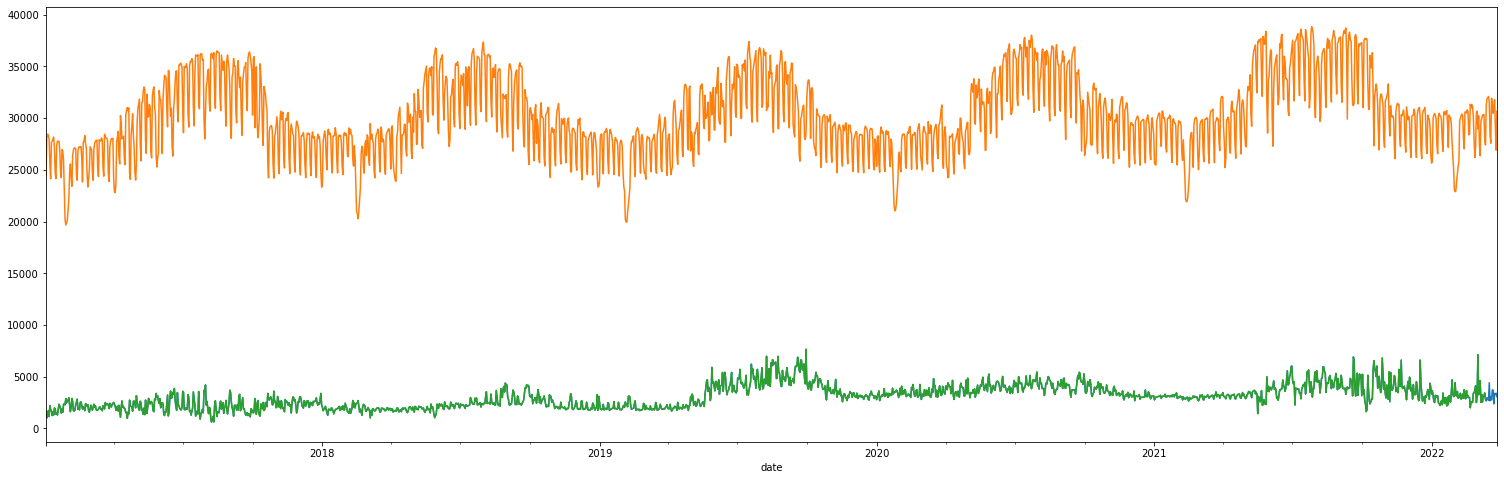

In [65]:
raw_data_tmp = raw_data[:]
raw_data_tmp.set_index('date',inplace=True)
raw_data_tmp['op_reserve'].plot(label='first_data', figsize=(26,8))
raw_data_tmp['peak_supply'].plot(label='first_data', figsize=(26,8))

train_tmp = train[:]
train_tmp.set_index('date',inplace=True)
train_tmp['op_reserve'].plot(label='first_data', figsize=(26,8))

<AxesSubplot:xlabel='date'>

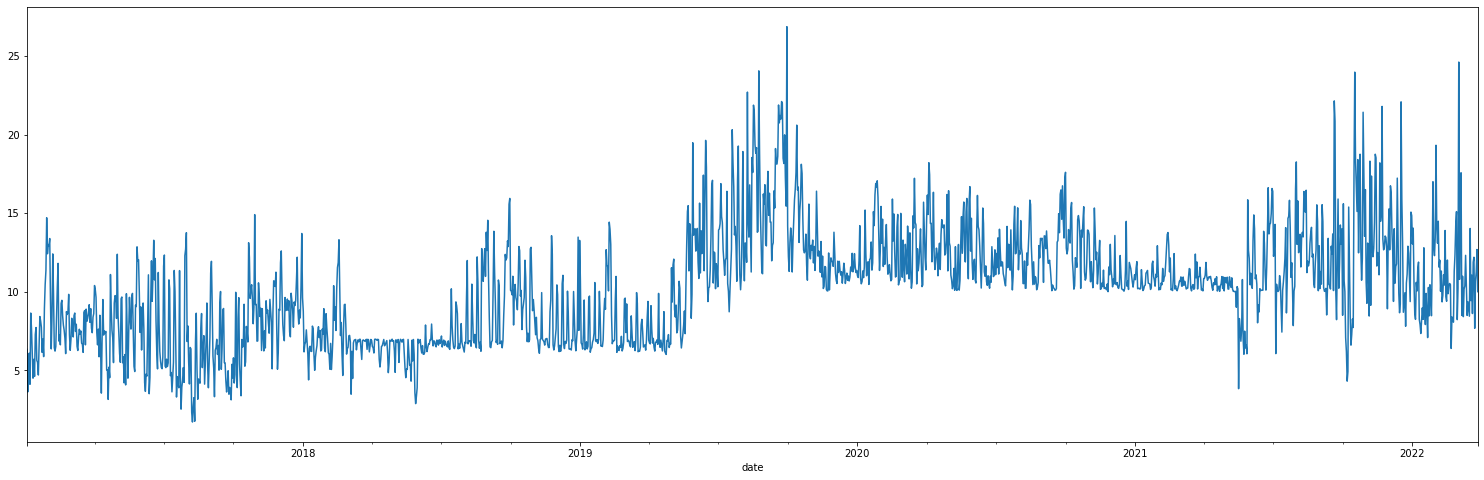

In [66]:
raw_data_tmp['prcnt_op_reserve'].plot(label='first_data', figsize=(26,8))

## FB Prophet

### 先預測尖峰供電

In [67]:
prophet_data = train[:]
prophet_data.rename(columns={first_forecast: 'y', 'date': 'ds'}, inplace=True)
prophet_data.reset_index(inplace=True)

In [68]:
model = Prophet(daily_seasonality=False, 
                yearly_seasonality=True, 
                weekly_seasonality=True,
                changepoint_range=0.55,
                seasonality_mode='additive')
for regressor in regressors_first:
    model.add_regressor(regressor)
model.fit(prophet_data)

In [69]:
prophet_data.tail()

,index,ds,is_holiday,year,month,day,day_of_week,op_reserve,prcnt_op_reserve,y
1892,1892,2022-03-09,0,2022,3,9,2,2550.0,8.42,30285.035629
1893,1893,2022-03-10,0,2022,3,10,3,3088.0,10.18,30333.988212
1894,1894,2022-03-11,0,2022,3,11,4,3148.0,10.37,30356.798457
1895,1895,2022-03-12,2,2022,3,12,5,3438.0,12.32,27905.844156
1896,1896,2022-03-13,2,2022,3,13,6,2839.0,10.36,27403.474903


In [70]:
future = test.rename(columns={'date': 'ds'})
# future.drop(['op_reserve'], axis = 1, inplace=True)
future.head()

,ds,is_holiday,year,month,day,day_of_week,op_reserve,prcnt_op_reserve,peak_supply
1897,2022-03-14,0,2022,3,14,0,2659.0,8.50,31282.352941
1898,2022-03-15,0,2022,3,15,1,2986.0,9.37,31867.662753
1899,2022-03-16,0,2022,3,16,2,2859.0,8.94,31979.865772
1900,2022-03-17,0,2022,3,17,3,2712.0,8.45,32094.674556
1901,2022-03-18,0,2022,3,18,4,4424.0,14.03,31532.430506


In [71]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,day,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-14,31083.182997,29731.593351,32901.432644,31083.182997,31083.182997,202.732723,202.732723,202.732723,0.921609,...,1711.093576,1711.093576,1711.093576,-2682.091793,-2682.091793,-2682.091793,0.0,0.0,0.0,31285.915720
1,2022-03-15,31084.916541,29918.001701,33125.519649,31084.916541,31084.916541,473.465727,473.465727,473.465727,0.367124,...,1711.093576,1711.093576,1711.093576,-2676.486079,-2676.486079,-2676.486079,0.0,0.0,0.0,31558.382268
2,2022-03-16,31086.650085,29907.008550,33212.287621,31086.650085,31086.650085,496.181797,496.181797,496.181797,-0.187362,...,1711.093576,1711.093576,1711.093576,-2667.896574,-2667.896574,-2667.896574,0.0,0.0,0.0,31582.831882
3,2022-03-17,31088.383629,30141.380901,33128.438285,31088.383629,31088.383629,499.152785,499.152785,499.152785,-0.741847,...,1711.093576,1711.093576,1711.093576,-2655.838654,-2655.838654,-2655.838654,0.0,0.0,0.0,31587.536414
4,2022-03-18,31090.117173,29877.736275,32962.245654,31090.117173,31090.117173,328.594711,328.594711,328.594711,-1.296332,...,1711.093576,1711.093576,1711.093576,-2639.948254,-2639.948254,-2639.948254,0.0,0.0,0.0,31418.711883


         date      forecast        actual
0  2022-03-14  31285.915720  31282.352941
1  2022-03-15  31558.382268  31867.662753
2  2022-03-16  31582.831882  31979.865772
3  2022-03-17  31587.536414  32094.674556
4  2022-03-18  31418.711883  31532.430506
5  2022-03-19  27819.489664  28336.864407
6  2022-03-20  26930.997382  27576.853526
7  2022-03-21  31408.643089  31914.153132
8  2022-03-22  31707.709893  31439.393939
9  2022-03-23  31759.431167  30467.213115
10 2022-03-24  31791.176143  31002.604167
11 2022-03-25  31648.274782  31779.026217
12 2022-03-26  28073.015127  29128.888889
13 2022-03-27  27205.749299  26903.073286
14 2022-03-28  31701.201002  30659.340659
RMSE = 639.6086834581379


<AxesSubplot:xlabel='date'>

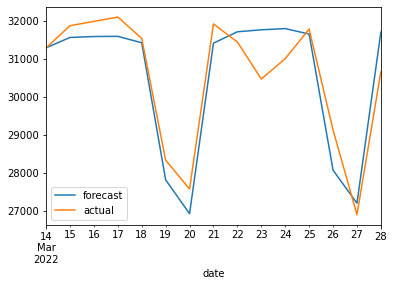

In [72]:
'''
整理結果 collate the results
'''
forecast_simplified = forecast[-n_tests:][['ds', 'yhat']]
forecast_simplified.columns = ['date', 'forecast']
# forecast_simplified['actual'] = raw_data['op_reserve'][-n_tests:].values
forecast_simplified['actual'] = raw_data[-n_tests:][first_forecast].values
print(forecast_simplified)
'''
印出結果
'''
rmse = mean_squared_error(forecast_simplified['forecast'], forecast_simplified['actual'], squared=False)
print('RMSE =', rmse)
forecast_simplified.set_index('date',inplace=True)
forecast_simplified.plot(label='test_data')

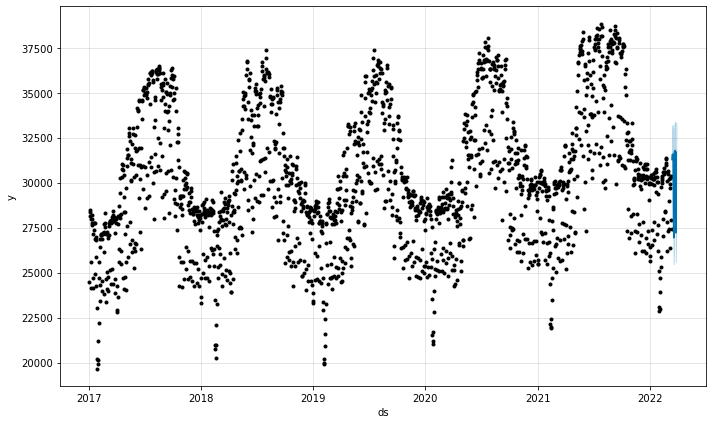

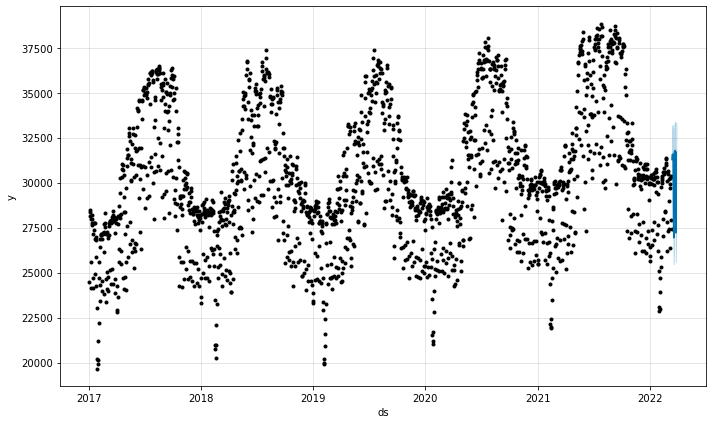

In [73]:
model.plot(forecast)

### 將預測結果代入

In [74]:
if first_forecast in dependencies:
    test[first_forecast] = forecast_simplified['forecast'].values

### 預測第二個值

In [75]:
'''
split training set and testing set
'''
train = raw_data[start_offset_second:-n_tests]
test = raw_data[-n_tests:]

In [76]:
prophet_data = train[:]
prophet_data.rename(columns={second_forecast: 'y', 'date': 'ds'}, inplace=True)
prophet_data.reset_index(inplace=True)

In [77]:
model = Prophet(daily_seasonality=False, 
                yearly_seasonality=True, 
                weekly_seasonality=False, 
                seasonality_mode='additive',
                changepoint_range=0.9,
                changepoint_prior_scale=100,
                seasonality_prior_scale=100)
for regressor in regressors_second:
    model.add_regressor(regressor)
model.fit(prophet_data)

In [78]:
future = test.rename(columns={'date': 'ds'})
# future.drop(['op_reserve'], axis = 1, inplace=True)
future.head()

,ds,is_holiday,year,month,day,day_of_week,op_reserve,prcnt_op_reserve,peak_supply
1897,2022-03-14,0,2022,3,14,0,2659.0,8.50,31282.352941
1898,2022-03-15,0,2022,3,15,1,2986.0,9.37,31867.662753
1899,2022-03-16,0,2022,3,16,2,2859.0,8.94,31979.865772
1900,2022-03-17,0,2022,3,17,3,2712.0,8.45,32094.674556
1901,2022-03-18,0,2022,3,18,4,4424.0,14.03,31532.430506


In [79]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,day,...,year,year_lower,year_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-14,-6.368153,7.802333,12.011406,-6.368153,-6.368153,16.222098,16.222098,16.222098,-0.070099,...,22.300726,22.300726,22.300726,-3.410838,-3.410838,-3.410838,0.0,0.0,0.0,9.853944
1,2022-03-15,-6.388124,7.295106,11.629007,-6.388124,-6.388124,15.725057,15.725057,15.725057,-0.027924,...,22.300726,22.300726,22.300726,-3.374831,-3.374831,-3.374831,0.0,0.0,0.0,9.336933
2,2022-03-16,-6.408094,7.256987,11.458721,-6.408094,-6.408094,15.691924,15.691924,15.691924,0.014251,...,22.300726,22.300726,22.300726,-3.339869,-3.339869,-3.339869,0.0,0.0,0.0,9.283830
3,2022-03-17,-6.428065,7.105885,11.426797,-6.428065,-6.428065,15.654595,15.654595,15.654595,0.056426,...,22.300726,22.300726,22.300726,-3.306543,-3.306543,-3.306543,0.0,0.0,0.0,9.226530
4,2022-03-18,-6.448035,7.794884,11.985306,-6.448035,-6.448035,16.280472,16.280472,16.280472,0.098601,...,22.300726,22.300726,22.300726,-3.275396,-3.275396,-3.275396,0.0,0.0,0.0,9.832436


RMSE = 1.608476385509087


<AxesSubplot:xlabel='date'>

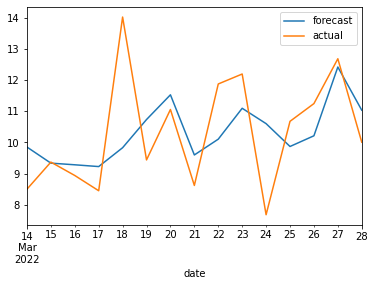

In [80]:
'''
整理結果 collate the results
'''
forecast_simplified = forecast[-n_tests:][['ds', 'yhat']]
forecast_simplified.columns = ['date', 'forecast']
# forecast_simplified['actual'] = raw_data['op_reserve'][-n_tests:].values
forecast_simplified['actual'] = raw_data[-n_tests:][second_forecast].values
'''
印出結果
'''
rmse = mean_squared_error(forecast_simplified['forecast'], forecast_simplified['actual'], squared=False)
print('RMSE =', rmse)
forecast_simplified.set_index('date',inplace=True)
forecast_simplified.plot(label='test_data')

In [81]:
if second_forecast in dependencies:
    test[second_forecast] = forecast_simplified['forecast'].values

### 接著預測備轉容量

In [82]:
'''
split training set and testing set
'''
train = raw_data[start_offset_final:-n_tests]
test = raw_data[-n_tests:]

In [83]:
prophet_data = train[:]
prophet_data.rename(columns={'op_reserve': 'y', 'date': 'ds'}, inplace=True)
prophet_data.reset_index(inplace=True)

In [84]:
model = Prophet(daily_seasonality=False, 
                yearly_seasonality=False, 
                weekly_seasonality=False, 
                seasonality_mode='additive',
                changepoint_range=0.95,
                changepoint_prior_scale=100,
                seasonality_prior_scale=100
                )
for regressor in regressors_op_reserve:
    model.add_regressor(regressor)
model.fit(prophet_data)

In [85]:
future = test.rename(columns={'date': 'ds'})
future.head()

,ds,is_holiday,year,month,day,day_of_week,op_reserve,prcnt_op_reserve,peak_supply
1897,2022-03-14,0,2022,3,14,0,2659.0,8.50,31282.352941
1898,2022-03-15,0,2022,3,15,1,2986.0,9.37,31867.662753
1899,2022-03-16,0,2022,3,16,2,2859.0,8.94,31979.865772
1900,2022-03-17,0,2022,3,17,3,2712.0,8.45,32094.674556
1901,2022-03-18,0,2022,3,18,4,4424.0,14.03,31532.430506


In [86]:
forecast = model.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,day_of_week,...,peak_supply,peak_supply_lower,peak_supply_upper,prcnt_op_reserve,prcnt_op_reserve_lower,prcnt_op_reserve_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-14,3230.926051,2507.976742,2754.841204,3230.926051,3230.926051,-602.483101,-602.483101,-602.483101,-10.238548,...,87.887611,87.887611,87.887611,-702.202190,-702.202190,-702.202190,0.0,0.0,0.0,2628.442950
1,2022-03-15,3230.838367,2829.992951,3080.821349,3230.838367,3230.838367,-278.579061,-278.579061,-278.579061,-6.827925,...,145.371921,145.371921,145.371921,-439.193083,-439.193083,-439.193083,0.0,0.0,0.0,2952.259306
2,2022-03-16,3230.750682,2708.129384,2956.986847,3230.750682,3230.750682,-394.141788,-394.141788,-394.141788,-3.417302,...,156.391577,156.391577,156.391577,-569.186090,-569.186090,-569.186090,0.0,0.0,0.0,2836.608894
3,2022-03-17,3230.662997,2576.929817,2830.480181,3230.662997,3230.662997,-527.587158,-527.587158,-527.587158,-0.006679,...,167.667151,167.667151,167.667151,-717.317656,-717.317656,-717.317656,0.0,0.0,0.0,2703.075840
4,2022-03-18,3230.575313,4218.041908,4456.207427,3230.575313,3230.575313,1107.490480,1107.490480,1107.490480,3.403944,...,112.448170,112.448170,112.448170,969.568340,969.568340,969.568340,0.0,0.0,0.0,4338.065793


RMSE = 55.75294655034831


,forecast,actual
date,,
2022-03-14,2628.442950,2659.0
2022-03-15,2952.259306,2986.0
2022-03-16,2836.608894,2859.0
2022-03-17,2703.075840,2712.0
2022-03-18,4338.065793,4424.0


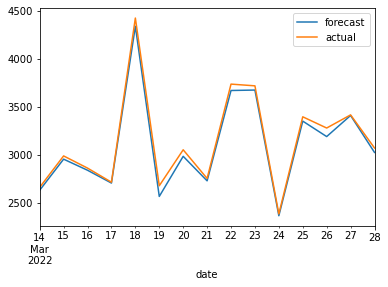

In [87]:
'''
整理結果 collate the results
'''
forecast_simplified = forecast[-n_tests:][['ds', 'yhat']]
forecast_simplified.columns = ['date', 'forecast']
# forecast_simplified['actual'] = raw_data['op_reserve'][-n_tests:].values
forecast_simplified['actual'] = raw_data[-n_tests:]['op_reserve'].values
'''
印出結果
'''
rmse = mean_squared_error(forecast_simplified['forecast'], forecast_simplified['actual'], squared=False)
print('RMSE =', rmse)
forecast_simplified.set_index('date',inplace=True)
forecast_simplified.plot(label='test_data')
forecast_simplified.head()

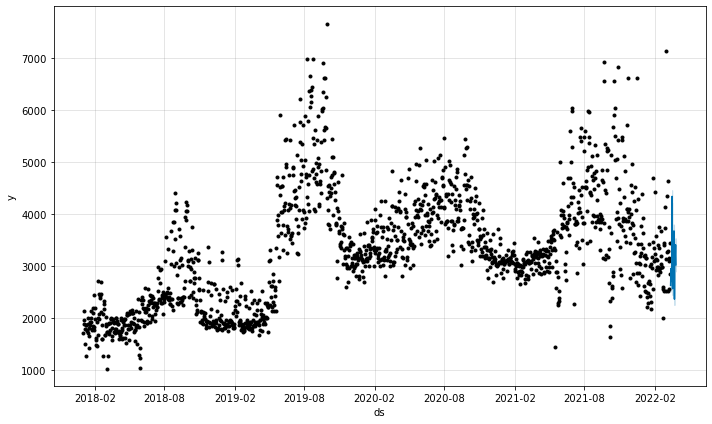

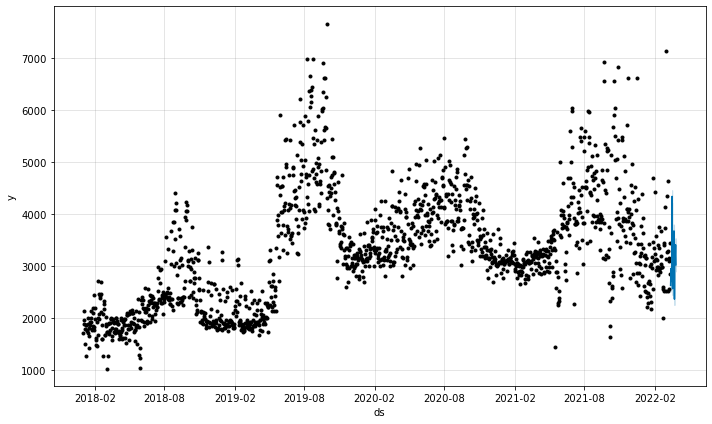

In [88]:
model.plot(forecast)

### 或是直接將兩者乘起來

RMSE = 0.0


<AxesSubplot:>

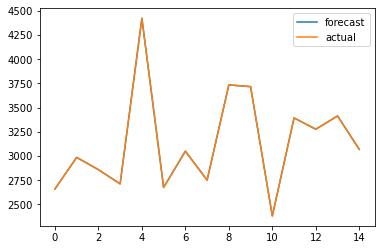

In [89]:
forecast_final= test[-n_tests:][['date', 'prcnt_op_reserve', 'peak_supply', 'op_reserve']]
forecast_final.reset_index(drop=True, inplace=True)
forecast_simplified.head()
for i, item in enumerate(forecast_final['op_reserve']):
    forecast_final['op_reserve'][i] = forecast_final['peak_supply'][i] * forecast_final['prcnt_op_reserve'][i] / 100
forecast_final['actual'] = raw_data[-n_tests:]['op_reserve'].values
forecast_final.rename(columns={'op_reserve': 'forecast'}, inplace=True)
forecast_final = forecast_final.loc[:,['forecast', 'actual']]
'''
印出結果
'''
rmse = mean_squared_error(forecast_final['forecast'], forecast_final['actual'], squared=False)
print('RMSE =', rmse)
forecast_final.plot(label='test_data')

In [90]:
forecast_final.head()

,forecast,actual
0,2659.0,2659.0
1,2986.0,2986.0
2,2859.0,2859.0
3,2712.0,2712.0
4,4424.0,4424.0


## Master Cell: Test Different Parameters
`start_offset_first`
`start_offset_second`
`multistep`

In [91]:
df_training = pd.read_csv('training_data.csv')
df_training = pd.DataFrame(df_training)
df_training['date']= pd.to_datetime(df_training['date'])

prophet_data = df_training[:-n_predictions].rename(columns={'peak_supply': 'y', 'date': 'ds'})
model_step_1 = Prophet(daily_seasonality=False, 
                        yearly_seasonality=True, 
                        weekly_seasonality=True,
                        changepoint_range=0.55,
                        seasonality_mode='additive')
for regressor in ['is_holiday', 'month', 'year', 'day']:
    model_step_1.add_regressor(regressor)
model_step_1.fit(prophet_data)
df_future = df_training[-n_predictions:].rename(columns={'peak_supply': 'y', 'date': 'ds'})
df_forecast_step_1 = model_step_1.predict(df_future)
df_forecast_step_1 = df_forecast_step_1[['ds', 'yhat']]
df_forecast_step_1.columns = ['date', 'peak_supply']

prophet_data = df_training[:-n_predictions].rename(columns={'date': 'ds', 'prcnt_op_reserve': 'y'})
model_step_2 = Prophet(daily_seasonality=False, 
                        yearly_seasonality=True, 
                        weekly_seasonality=False, 
                        seasonality_mode='additive',
                        changepoint_range=0.9,
                        changepoint_prior_scale=100,
                        seasonality_prior_scale=100)
for regressor in ['peak_supply', 'is_holiday', 'month', 'year', 'day']:
    model_step_2.add_regressor(regressor)
model_step_2.fit(prophet_data)
df_future = df_training[-n_predictions:].rename(columns={'peak_supply': 'y', 'date': 'ds'})
df_future['peak_supply'] = df_forecast_step_1['peak_supply'].values
df_forecast_step_2 = model_step_2.predict(df_future)
df_forecast_step_2 = df_forecast_step_2[['ds', 'yhat']]
df_forecast_step_2.columns = ['date', 'prcnt_op_reserve']

df_result = df_forecast_step_1.merge(df_forecast_step_2)
op_reserve = [float] * len(df_result['peak_supply'])
for i, item in enumerate (op_reserve):
    op_reserve[i] = df_result.loc[:,('peak_supply')][i] * df_result.loc[:,('prcnt_op_reserve')][i] / 100
df_result['op_reserve'] = op_reserve

df_result = df_result.loc[:, ['date', 'op_reserve']]

new_date = [str] * len(df_result['date'])
for i, date in enumerate(df_result['date']):
    new_date[i] = str(date).replace('-', '')[:8]
df_result['date'] = new_date

df_result.columns = ['date', 'operating_reserve(MW)']

df_result.to_csv(args.output, index=0)

NameError: name 'args' is not defined